In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import proylib

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:153: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  set_use_pygeos()
/tmp/ipykernel_10556/3575814356.py:5: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


2024-01-07 15:13:06 Configured OSMnx 1.1.2
2024-01-07 15:13:06 HTTP response caching is on


In [2]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'

query = f"SELECT * FROM {schema}.{folder} WHERE \"CVEGEO\" = \'14039\'"

hex_gdf = proylib.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(1214, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,89498c9616bffff,"POLYGON ((-103.35105 20.65207, -103.34983 20.6...",14039,Guadalajara,Guadalajara,urban
1,89498c97303ffff,"POLYGON ((-103.26784 20.65891, -103.26662 20.6...",14039,Guadalajara,Guadalajara,urban


### Census data

In [3]:
schema = 'censo'
folder = 'hex_censo_mza_2020_res9'

query = f"SELECT hex_id_9,pobtot FROM {schema}.{folder} WHERE  \"hex_id_9\" IN {str(tuple(list(hex_gdf.hex_id_9.unique())))}"
censo_gdf = proylib.df_from_query(query)

print(censo_gdf.shape)
censo_gdf.head(2)

(1127, 2)


,hex_id_9,pobtot
0,89498c944cbffff,1189.0
1,89498c95517ffff,1439.0


### Nodes, edges, graphs

In [47]:
hex_gdf = hex_gdf.to_crs("EPSG:4326")

G,nodes,edges = proylib.graph_from_hippo(hex_gdf, schema='osmnx', 
                    edges_folder='edges_speed', nodes_folder='nodes_elevation')

2024-01-07 16:04:43 Created graph from node/edge GeoDataFrames


### NDVI

In [5]:
ndvi_gdf = gpd.read_file('../data/processed/calles_verdes22.gpkg')
print(ndvi_gdf.shape)
ndvi_gdf.head(2)

(2650138, 16)


,osm_id,bridge,highway,layer,name,oneway,smoothness,surface,tunnel,width,z_index,ID,_ID,__sum,__mean,geometry
0,4564450,None,residential,None,Avenida de la Cruz,None,None,None,None,None,3,1,1.0,NaN,NaN,GEOMETRYCOLLECTION EMPTY
1,4564450,None,residential,None,Avenida de la Cruz,None,None,None,None,None,3,2,2.0,NaN,NaN,GEOMETRYCOLLECTION EMPTY


In [12]:
ndvi_gdf = ndvi_gdf.explode()

Hexágonos de resolución 11 filtrando aquellos con NDVI > 0.2. Calcular área. Extraer centroides. Intersección con hexágonos. Sumar área. Dividir entre población.

### Green spaces point

In [6]:
green_point = gpd.read_file('../data/processed/espacios_publicos_point_amg.geojson')
print(green_point.shape)
green_point.head(2)

(309845, 15)


,Nombre_del,Estado_del,Nombre_de0,ID,Tipo_de_es,Superficie,layer,path,vertex_index,vertex_part,vertex_part_ring,vertex_part_index,distance,angle,geometry
0,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,0,0,0,0,0.000000,246.816795,POINT (654289.910 2262353.862)
1,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,1,0,0,1,3.101983,264.661886,POINT (654286.904 2262353.098)


### Green spaces area

In [7]:
green_area = gpd.read_file('../data/processed/espacios_publicos_amg.geojson')
print(green_area.shape)
green_area.head(2)

(4271, 9)


,Nombre_del,Estado_del,Nombre_de0,ID,Tipo_de_es,Superficie,layer,path,geometry
0,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"POLYGON ((654289.910 2262353.862, 654286.904 2..."
1,Zapopan,�reas de Protecci�n a acu�feros,Bosque Pedag�gico del Agua,1,None,None,vwBosque_urbano_POTmet_sm,/home/edgaregurrola/Repos/freelance/gdl10k/dat...,"POLYGON ((654650.160 2262883.428, 654642.771 2..."


## Average NDVI

In [13]:
hex_gdf = hex_gdf.to_crs("EPSG:32613")
ndvi_hex = ndvi_gdf.overlay(hex_gdf, how='intersection')

In [14]:
# calculate length
ndvi_hex['length'] = ndvi_hex.length

# calculate total length by hexagon
ndvi_len = ndvi_hex[['hex_id_9','length']].groupby(['hex_id_9']).sum()
ndvi_len = ndvi_len.reset_index()
ndvi_len = ndvi_len.rename(columns={'length':'length_tot'})

# calculate percentage
ndvi_hex = ndvi_hex.merge(ndvi_len, on='hex_id_9')
ndvi_hex['pct_length'] = ndvi_hex['length'] / ndvi_hex['length_tot']

# calculate weight
ndvi_hex['wgt_ndvi'] = ndvi_hex['pct_length'] * ndvi_hex['__mean']

# calculate weighted mean
ndvi_hex = ndvi_hex[['hex_id_9','wgt_ndvi']].groupby(['hex_id_9']).sum()
ndvi_hex = ndvi_hex.reset_index()

print(ndvi_hex.shape)
ndvi_hex.head(2)

In [17]:
hex_ndvi = hex_gdf.merge(ndvi_hex, on='hex_id_9', how='outer')
print(hex_ndvi.shape)
hex_ndvi.head(2)

(1214, 7)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,wgt_ndvi
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,0.068984
1,89498c97303ffff,"POLYGON ((680447.784 2285361.927, 680573.012 2...",14039,Guadalajara,Guadalajara,urban,0.250060


<AxesSubplot: >

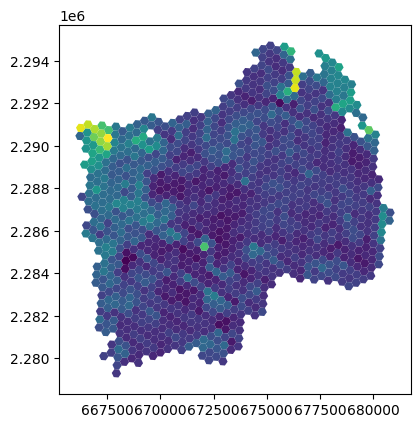

In [18]:
hex_ndvi.plot('wgt_ndvi')

## m² per person

In [42]:
green_hex = green_area.overlay(hex_gdf, how='intersection')
green_hex['area_m2'] = green_hex.area
green_hex = green_hex.groupby('hex_id_9').sum()

hex_green = hex_gdf.merge(green_hex, on='hex_id_9', how='outer')
hex_green = hex_green.fillna(0)
print(hex_green.shape)
hex_green.head(2)

(1214, 7)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,area_m2
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,503.768594
1,89498c97303ffff,"POLYGON ((680447.784 2285361.927, 680573.012 2...",14039,Guadalajara,Guadalajara,urban,83287.288973


In [43]:
hex_green = hex_green.merge(censo_gdf, on='hex_id_9', how='outer')
hex_green.loc[hex_green.pobtot==0,'pobtot'] = 1
hex_green['area_pob'] = hex_green['area_m2'] / hex_green['pobtot']
hex_green = hex_green.fillna(0)
print(hex_green.shape)
hex_green.head(2)

(1214, 9)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,area_m2,pobtot,area_pob
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,503.768594,119.0,4.233350
1,89498c97303ffff,"POLYGON ((680447.784 2285361.927, 680573.012 2...",14039,Guadalajara,Guadalajara,urban,83287.288973,424.0,196.432285


<AxesSubplot: >

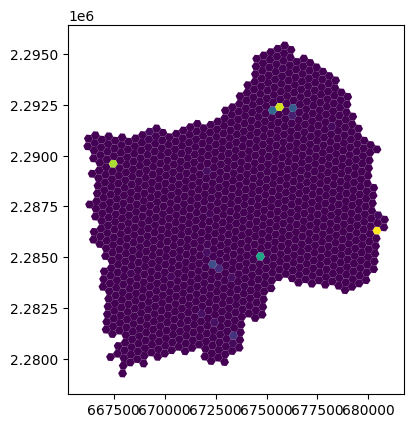

In [45]:
hex_green.plot('area_pob')

## Proximity to green spaces

In [49]:
green_point = green_point.to_crs("EPSG:4326")
green_osmid = proylib.find_nearest(G, nodes, green_point, return_distance= True)
nodes_green = proylib.calculate_distance_nearest_poi(green_osmid, nodes, 
                                       edges, 'ep', 'osmid', wght='time_min')
nodes_green = nodes_green.reset_index()
nodes_green.head(4)

,osmid,index,x,y,street_count,elevation,geometry,dist_ep
0,28751344,0,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153),2.523255
1,28753224,1,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065),3.938320
2,28757751,2,-103.307356,20.708526,3.0,1548.0,POINT (-103.30736 20.70853),0.000000
3,28757777,3,-103.306806,20.710093,4.0,1548.0,POINT (-103.30681 20.71009),0.000000


In [51]:
nodes_green = nodes_green.to_crs("EPSG:32613")
hex_gdf = hex_gdf.to_crs("EPSG:32613")
hex_prox = proylib.group_by_hex_mean(nodes_green, hex_gdf, 9, 'dist_ep')
print(hex_prox.shape)
hex_prox.head(2)

(1214, 12)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,index,x,y,street_count,elevation,dist_ep
0,89498c9616bffff,"POLYGON ((671785.185 2284513.845, 671910.418 2...",14039,Guadalajara,Guadalajara,urban,57127.058824,-103.351698,20.654039,2.294118,1540.882353,2.888454
1,89498c97303ffff,"POLYGON ((680447.784 2285361.927, 680573.012 2...",14039,Guadalajara,Guadalajara,urban,102336.277778,-103.268420,20.660764,2.555556,1523.611111,5.575029


<AxesSubplot: >

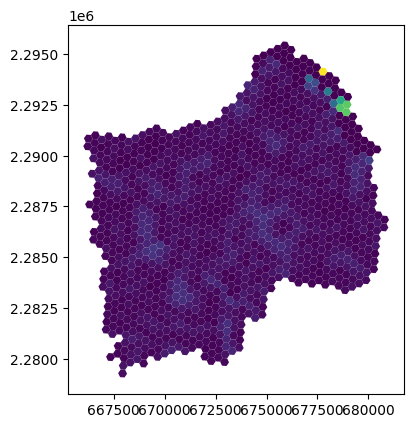

In [52]:
hex_prox.plot('dist_ep')

## Merge data

In [53]:
hex_env = hex_gdf.merge(hex_ndvi[['hex_id_9','wgt_ndvi']], on='hex_id_9', how='left')
hex_env = hex_env.merge(hex_green[['hex_id_9','area_m2','area_pob']], on='hex_id_9', how='left')
hex_env = hex_env.merge(hex_prox[['hex_id_9','dist_ep']], on='hex_id_9', how='left')

In [54]:
hex_env.to_file('../data/processed/hex_environmental.geojson')